# MSE 211 MDP Project

We can do the project here

In [ ]:
import random
from enum import Enum
from abc import ABC, abstractmethod, abstractproperty
import copy
# States
# Actions

# States 
# Actions
# Rewards
class UpdateRule(Enum):
    DURING_SWEEP = "DURING SWEEP"
    AFTER_SWEEP = "AFTER SWEEP"

class ValueIterator(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def get_states(self, states, **kwargs):
        pass

    @abstractproperty
    def update_rule(self):
        pass

    @property
    def name(self):
        return type(self).__name__

    
    def iterate(self, mdp, gamma, V_0):
        V = V_0
        V_copy = None if self.update_rule != UpdateRule.AFTER_SWEEP else copy.deepcopy(V_0)
        
        # If update during sweep, use the same v
        # If not updating during sweep, store and update later
        
        for state in self.get_states(mdp.states):
            costs = []
            for action in mdp.actions(state):
                # Immediate reward
                state_action_cost = mdp.reward(state, action)
                for (next_state, p) in mdp.transition(state, action):
                    # Values based on next states
                    state_action_cost += gamma * p * V[next_state]

                costs.append(state_action_cost)
                

            new_cost = max(costs)
            
            if self.update_rule == UpdateRule.DURING_SWEEP:
                V[state] = new_cost
                
            elif self.update_rule == UpdateRule.AFTER_SWEEP:
                V_copy[state] = new_cost

        # Return values at the end
        if self.update_rule == UpdateRule.AFTER_SWEEP:
            return V_copy
        elif self.update_rule == UpdateRule.DURING_SWEEP:
            return V



class ClassicVI(ValueIterator):
    def get_states(self, states, **kwargs):
        return states

    @property
    def update_rule(self):
        return UpdateRule.AFTER_SWEEP

class RandomVI(ValueIterator):
    def __init__(self, k):
        super().__init__()
        self.k = k
    
    def get_states(self, states, **kwargs):
        return random.sample(states, self.k)

    @property
    def update_rule(self):
        return UpdateRule.AFTER_SWEEP

    @property
    def name(self):
        return "{} (k={})".format(type(self).__name__, self.k)

class CyclicVI(ValueIterator):
    def get_states(self, states, **kwargs):
        return states

    @property
    def update_rule(self):
        return UpdateRule.DURING_SWEEP

class RandomCyclicVI(ValueIterator):
    def get_states(self, states, **kwargs):
        return random.sample(states)

    @property
    def update_rule(self):
        return UpdateRule.DURING_SWEEP


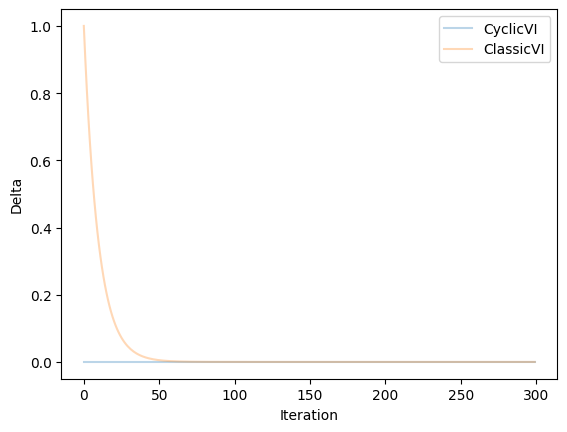

In [48]:
class Solver:
    def __init__(self, iterator, mdp, gamma):
        self.iterator = iterator
        self.mdp = mdp
        self.gamma = gamma
        self.solution = None
        self.deltas = None

    def solve(self, steps=100):
        V = { state: 0 for state in self.mdp.states}
        deltas = []
        for i in range(steps):
            V_new = self.iterator.iterate(self.mdp, self.gamma, V)
            
            # Calculate the delta by seeing the biggest change between the two versions
            delta = max([abs(V_new[state] - V[state]) for state in V])
            deltas.append(delta)

            V = V_new

        self.solution = V
        self.deltas = deltas


    def plot_delta(self):
        deltas = self.deltas
        if deltas is not None:
            label = self.iterator.name
            plt.plot(deltas, label=label, alpha=0.3)
            plt.xlabel("Iteration")
            plt.ylabel("Delta")

g = GridWorld(5)

iterators = [CyclicVI(), ClassicVI()]#[RandomVI(k=k) for k in range(1, 26, 5)]

for iterator in iterators:
    solver = Solver(iterator, g, 0.9)
    solver.solve(steps = 300)
    solver.plot_delta()
    
plt.legend()
plt.show()


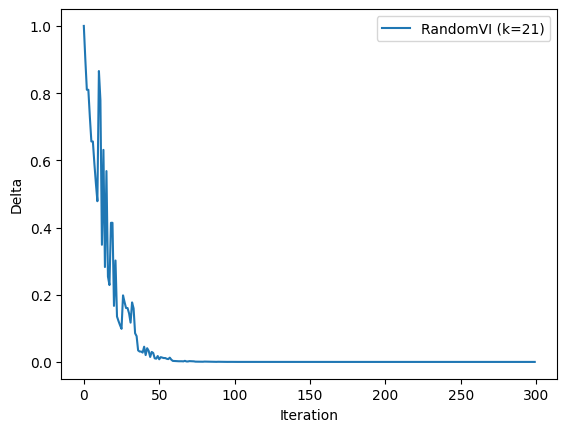

In [40]:
solver.plot_delta()
plt.legend()

In [12]:
type(iterator).__name__

'ClassicVI'

In [57]:
"""
MDPSolver:

Model/MDP
Iteration Method

Iterate until end

"""

"""
Iteration method:
Classic VI,
Random VI
Cyclic VI,
Random Cyclic VI

All iteration methods:
Take states, actions, rewards, gamma, initial values

Ouptuts
new values vector for each state
"""


"""class MDP:


    def iterate(self):
        # Get stored values
        for state in self.states:
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            value[state] = max(vals)
        # Update all values after state is stored


    def iterate_random_VI(self, k):
        states = random.sample(self.states, k)

        for state in self.states:
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            value[state] = max(vals)
        # Update all values after state is stored


    def iterate_cyclic_VI(self):
        # Get stored values
        for state in self.states:
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            # Update stored values
            value[state] = max(vals)


    def iterate_cyclic_VI_random(self):
        # Get stored values
        for state in random.sample(self.states):
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            # Update stored values
            value[state] = max(vals)


"""

'class MDP:\n\n\n    def iterate(self):\n        # Get stored values\n        for state in self.states:\n            \n            vals = []\n            for action in state.actions:\n                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)\n                vals.append(value_cost)\n\n            value[state] = max(vals)\n        # Update all values after state is stored\n\n\n    def iterate_random_VI(self, k):\n        states = random.sample(self.states, k)\n\n        for state in self.states:\n            vals = []\n            for action in state.actions:\n                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)\n                vals.append(value_cost)\n\n            value[state] = max(vals)\n        # Update all values after state is stored\n\n\n    def iterate_cyclic_VI(self):\n        # Get stored values\n        for state in self.states:\n            \n            vals = []\n            for action

In [ ]:
class MDP(ABC):
    def __init__(self, states):
        self.states = states

    @abstractmethod
    def prob(self, s, a):
        pass

    @abstractmethod
    def reward(self, s, a):
        pass

    @abc.abstractproperty
    def states(self):
        pass

